# Heart Attack Analysis
---

## Traditionoal ML :: Deep Learning 예측 비교








In [ ]:
from google.colab import files
uploaded = files.upload()

Saving heart.csv to heart.csv
Saving heart_oversampling.csv to heart_oversampling.csv
Saving o2Saturation.csv to o2Saturation.csv
Saving Test_data.csv to Test_data.csv
Saving Train_data.csv to Train_data.csv


# 1. Data Preprocessing

---



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics, regularizers
import warnings
warnings.filterwarnings("ignore")

import IPython
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, model_selection, linear_model, ensemble,neighbors, preprocessing
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Activation

In [ ]:
df = pd.read_csv("/content/heart.csv")

In [ ]:
heart_target = df[['output']].copy()
heart_data = df.copy()
del heart_data['output']

In [ ]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## 1.1 output 유무에 따른 양적변수 분포.

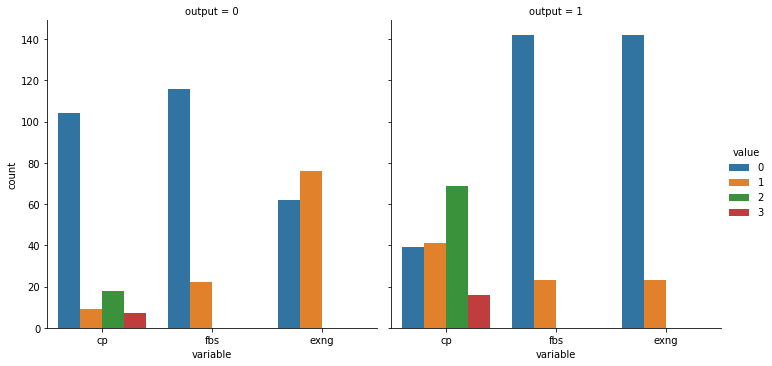

In [ ]:
df_long = pd.melt(df, id_vars=['output'], value_vars=['cp','fbs', 'exng'])
sns.catplot(x="variable", hue="value", col="output",
                data=df_long, kind="count");

## 1.2 BMI 센서를 통해 가져온 콜레스테롤(mg/dl) -> outlier 판단

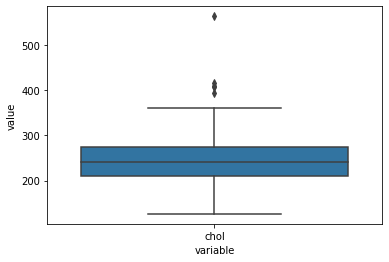

In [ ]:
chol = df.loc[:,['chol']]
sns.boxplot(x = 'variable',y = 'value',data = chol.melt())

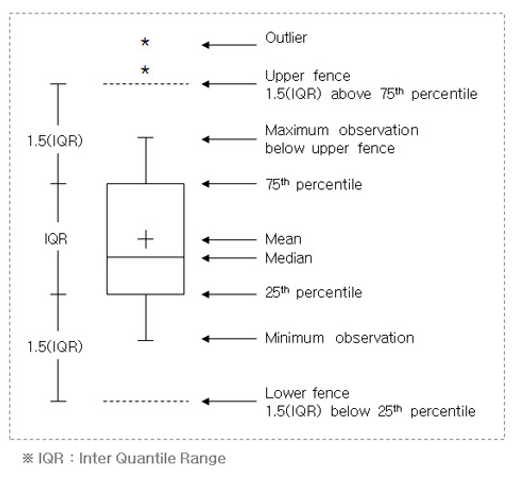

In [ ]:
df.drop(df[(df['chol'] > 500)].index,inplace=True)
print("Outlier {0} cases".format(df[df['chol']>500].shape[0]))
#oulier drop

Outlier 0 cases


## 1.3. 변수간 상관관계


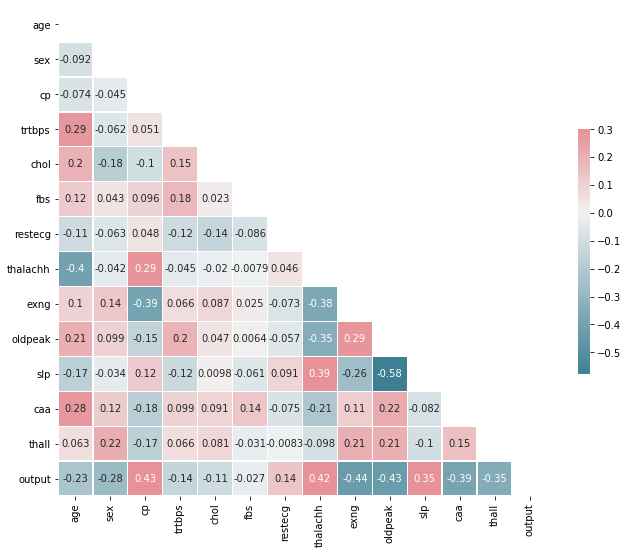

In [ ]:
corr = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
#흉통을 유형별로 나타낸 feature가 output에 가장 많은 영향을 주는 걸로 판단.

## 1.5 Data Preprocessing for DL


In [ ]:
train_data, test_data, train_label, test_label = model_selection.train_test_split(heart_data, heart_target,
                                                                                 test_size=0.3,
                                                                                 random_state=40)

### 1.5.1 over_sampling - SMOTE

In [ ]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# 모델설정
sm = SMOTE(ratio='auto', kind='regular')

for i in range(3):
  # train데이터를 넣어 복제함
  X_resampled, y_resampled = sm.fit_sample(train_data,train_label)
  print('After OverSampling, the shape of train_X: {}'.format(X_resampled.shape))
  print('After OverSampling, the shape of train_y: {} '.format(y_resampled.shape))

  print("After OverSampling, counts of label '1': {}".format(sum(y_resampled==1)))
  print("After OverSampling, counts of label '0': {}\n".format(sum(y_resampled==0)))
  X_resampled = pd.DataFrame(X_resampled)
  y_resampled = pd.DataFrame(y_resampled)

  #복제된 샘플과 원본 데이터 셋 concat
  train_data = np.concatenate((train_data, X_resampled), axis=0)
  train_label = np.concatenate((train_label, y_resampled), axis=0)
  
#Result
print("결과 샘플 수",train_data.shape)
print("결과 샘플 수",train_label.shape)

After OverSampling, the shape of train_X: (228, 13)
After OverSampling, the shape of train_y: (228,) 
After OverSampling, counts of label '1': 114
After OverSampling, counts of label '0': 114

After OverSampling, the shape of train_X: (456, 13)
After OverSampling, the shape of train_y: (456,) 
After OverSampling, counts of label '1': 228
After OverSampling, counts of label '0': 228

After OverSampling, the shape of train_X: (912, 13)
After OverSampling, the shape of train_y: (912,) 
After OverSampling, counts of label '1': 456
After OverSampling, counts of label '0': 456

결과 샘플 수 (1808, 13)
결과 샘플 수 (1808, 1)


In [ ]:
df_oversampling = np.concatenate((train_data, train_label), axis=1)

In [ ]:
df_oversampling = pd.DataFrame(df_oversampling)

In [ ]:
df_oversampling.columns = ['age', 'sex', 'cp', 'trtbps', 'chol','fbs', 'restecg', 'thalachh', 'exng', 'oldpeak','slp', 'caa', 'thall','output']
df_oversampling['sex'] = df_oversampling['sex'].astype(int)
df_oversampling['cp'] = df_oversampling['cp'].astype(int)
df_oversampling['fbs'] = df_oversampling['fbs'].astype(int)
df_oversampling['restecg'] = df_oversampling['restecg'].astype(int)
df_oversampling['exng'] = df_oversampling['exng'].astype(int)
df_oversampling['slp'] = df_oversampling['slp'].astype(int)
df_oversampling['caa'] = df_oversampling['caa'].astype(int)
df_oversampling['thall'] = df_oversampling['thall'].astype(int)
df_oversampling['output'] = df_oversampling['output'].astype(int)
df_oversampling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1808 entries, 0 to 1807
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1808 non-null   float64
 1   sex       1808 non-null   int64  
 2   cp        1808 non-null   int64  
 3   trtbps    1808 non-null   float64
 4   chol      1808 non-null   float64
 5   fbs       1808 non-null   int64  
 6   restecg   1808 non-null   int64  
 7   thalachh  1808 non-null   float64
 8   exng      1808 non-null   int64  
 9   oldpeak   1808 non-null   float64
 10  slp       1808 non-null   int64  
 11  caa       1808 non-null   int64  
 12  thall     1808 non-null   int64  
 13  output    1808 non-null   int64  
dtypes: float64(5), int64(9)
memory usage: 197.9 KB


### 1.5.2 Scaling for DL

In [ ]:
df_oversampling = pd.read_csv('/content/Train_data.csv')
df_oversampling = df_oversampling.drop(['Unnamed: 0'],axis = 1)

train_label = df_oversampling[['output']].copy()
train_data = df_oversampling.copy()
del train_data['output']

In [ ]:
test_dataset = pd.read_csv("/content/Test_data.csv")
test_dataset = test_dataset.drop(['Unnamed: 0'],axis = 1)
test_label = test_dataset[['output']].copy()
test_data = test_dataset.copy()
del test_data['output']

In [ ]:
enc = preprocessing.OneHotEncoder(categories='auto')

train_label = enc.fit_transform(train_label).toarray()
test_label = enc.fit_transform(test_label).toarray()

sc = preprocessing.StandardScaler()

train_data_scaled = sc.fit_transform(train_data)
test_data_scaled = sc.transform(test_data)

In [ ]:
print(train_data_scaled.shape)
print(test_data_scaled.shape)


(1808, 13)
(91, 13)


## 1.6 Dicussions



*   outlier로 판단되는 부분이 극히 적음.
*   심장병과 직접적인 양의 상관관계를 보이는 feature가 단 3개
*   결측값이 없어서 편함.
*   데이터가 많이 부족함.
*   OverSampling 진행여부 판단이 요구됨 (할지 안할지, 하면 얼마나 추가할지)





# 2. Traditional Machine Learining
---


##### scikit-learn/pycaret 버전호환 확인 필수(설치 시 SMOTE 실행 안됨)

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install pycaret

## 2.1 pycaret model setup

In [ ]:
df_oversampling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1808 entries, 0 to 1807
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1808 non-null   float64
 1   sex       1808 non-null   int64  
 2   cp        1808 non-null   int64  
 3   trtbps    1808 non-null   float64
 4   chol      1808 non-null   float64
 5   fbs       1808 non-null   int64  
 6   restecg   1808 non-null   int64  
 7   thalachh  1808 non-null   float64
 8   exng      1808 non-null   int64  
 9   oldpeak   1808 non-null   float64
 10  slp       1808 non-null   int64  
 11  caa       1808 non-null   int64  
 12  thall     1808 non-null   int64  
 13  output    1808 non-null   int64  
dtypes: float64(5), int64(9)
memory usage: 197.9 KB


In [ ]:
from pycaret.classification import *
model = setup(data=df_oversampling, 
              target='output', 
              train_size=0.7,
              session_id=123,
              )

## 2.2 top3 model 저장


In [ ]:
top = compare_models(n_select = 15)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9992,1.0000,1.0000,0.9985,0.9992,0.9984,0.9984,0.511
lightgbm,Light Gradient Boosting Machine,0.9992,1.0000,1.0000,0.9985,0.9992,0.9984,0.9984,0.120
dt,Decision Tree Classifier,0.9984,0.9984,1.0000,0.9969,0.9984,0.9968,0.9969,0.020
et,Extra Trees Classifier,0.9984,1.0000,1.0000,0.9969,0.9984,0.9968,0.9969,0.465
gbc,Gradient Boosting Classifier,0.9945,0.9997,1.0000,0.9893,0.9946,0.9889,0.9891,0.190
knn,K Neighbors Classifier,0.9850,0.9985,0.9765,0.9937,0.9848,0.9699,0.9705,0.121
ada,Ada Boost Classifier,0.9107,0.9823,0.9123,0.9114,0.9111,0.8214,0.8227,0.134
lda,Linear Discriminant Analysis,0.8633,0.9230,0.8967,0.8421,0.8681,0.7265,0.7288,0.022
ridge,Ridge Classifier,0.8625,0.0000,0.8967,0.8409,0.8675,0.7249,0.7274,0.017
lr,Logistic Regression,0.8523,0.9263,0.8731,0.8403,0.8558,0.7044,0.7060,0.629


## 2.3 Test Data 불러와서 ACC 확인


In [ ]:
def Accuracy_check(model_number):
  count = 0
  predictions = predict_model(top[model_number], data = test_dataset)
  for i in range(91):
    if predictions['output'][i] == predictions['Label'][i]:
      count = count + 1
  Acc = round(int(count)/90*100,1)
  return Acc

In [ ]:
print("Random Forest Classifier Accuracy :",Accuracy_check(0))
print("Light Gradient Boosting Machine Accuracy :",Accuracy_check(1))
print("Decision Tree Classifier Accuracy :",Accuracy_check(2))
print("Extra Trees Classifier :",Accuracy_check(3))
print("Gradient Boosting Classifier Accuracy :",Accuracy_check(4))

Random Forest Classifier Accuracy : 85.6
Light Gradient Boosting Machine Accuracy : 84.4
Decision Tree Classifier Accuracy : 78.9
Extra Trees Classifier : 86.7
Gradient Boosting Classifier Accuracy : 84.4


## 2.3 Model Ensemble::스태킹

### 2.3.1 model setup

In [ ]:
stack_model = setup(data = df_oversampling, target = 'output')

In [ ]:
stacker = stack_models(estimator_list = top[1:3], meta_model = top[0])
# 이전에 저장한 상위 3개의 모델을 기준 stack model
# 자동교차검증(개꿀) -> default fold 갯수 10개

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## 2.4 성능 지표 확인::

In [ ]:
evaluate_model(top[9]) # 설정된 Hyper-params의 값, AUC/Confusion matrix 등 성능 지표, Feature importance 등을 바로 확인할 수 있음

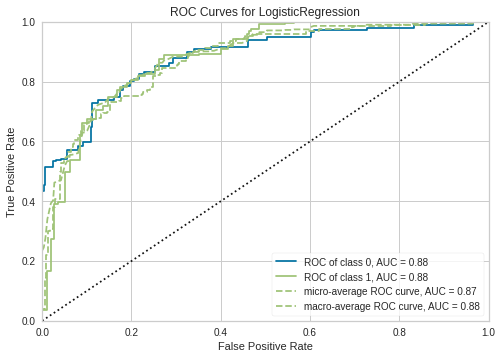

In [ ]:
Logistic = top[9]
plot_model(Logistic, plot = 'auc')
# plot_model(Logistic, plot='feature')
# plot_model(xgb, plot = 'confusion_matrix')

# 3. Deep Learning
---


In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 96 kB 3.8 MB/s 


In [ ]:
import kerastuner as kt

## 3.1 Keras Tuner


### 3.1.1 build_hyper_model

In [ ]:
def build_hyper_model(hp):
    
    model = keras.Sequential()
    model.add(layers.Dense(input_dim=13, units=16, activation='relu', kernel_initializer=initializers.he_normal(), kernel_regularizer=regularizers.l2(0.001))) 
    
    # hidden layer 조정 (1~3 중 최적값 선택)
    for i in range(hp.Int('num_layers', min_value=1, max_value=3)): 
        
        # perceptrons 수 조정 (32~512 사이에서 최적값 선택)
        hp_units = hp.Int('units_' + str(i), min_value=8, max_value=256, step=32)
        hp_activations = hp.Choice('activation_' + str(i), values=['relu', 'elu'])
        
        model.add(layers.Dense(units=hp_units, activation=hp_activations, 
                               kernel_initializer=initializers.he_normal()))

    model.add(layers.Dense(2, activation='softmax'))
    
    # optimizer의 학습률 조정(0.01, 0.001 또는 0.0001에서 최적 값 선택)
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy']) # tf.keras.metrics.CategoricalAccuracy()
    
    return model

### 3.1.2 튜너선택 -> BayesianOptimization

In [ ]:
tuner = kt.BayesianOptimization(build_hyper_model,
                                objective = 'val_accuracy', # Hyper-params tuning을 위한 목적함수 설정 (metric to minimize or maximize)
                                max_trials = 10, # 서로 다른 Hyper-params 조합으로 시도할 총 Trial 횟수 설정
                                directory = 'test_prac_dir', # Path to the working directory
                                project_name = 'heart_hyper_1') # Name to use as directory name for files saved by this Tuner
##==================================================================================
# from kerastuner.tuners import RandomSearch
# tuner = RandomSearch(
#     build_model, # HyperModel
#     objective='val_accuracy', #  최적화할 하이퍼모델
#     max_trials=10,
#     executions_per_trial=3, # 각 모델별 학습 회수
#     directory='/content/sample_data', # 사용된 parameter 저장할 폴더
#     project_name='RandomSearch_tune_res') # 사용된 parameter 저장할 폴더

# #==================================================================================
# from kerastuner.tuners import Hyperband
# tuner = kt.Hyperband(
#         build_model, # HyperModel
#         objective ='val_accuracy', #  최적화할 하이퍼모델
#         max_epochs =20, # 각 모델별 학습 회수
#         factor = 3,    # 한 번에 훈련할 모델 수 결정 변수
#         directory ='/content/sample_data', # 사용된 parameter 저장할 폴더
#         project_name ='Hyperband_tune_res') # 사용된 parameter 저장할 폴더

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 32, 'sampling': None}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


<h4> 교육자료 (Appendix) 6. Keras-tuner Bayesian-HPO on MNIST (Colab-only) 참조</h4>
<h4><a>https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=ko</a> 참조.</h4>
<h4>BayesianOptimization, RandomSearch, Hyperband 세 가지 튜너 선택 가능</h4>



### 3.1.3 Search

In [ ]:
tuner.search(train_data_scaled, 
             train_label, 
             batch_size=100, 
             epochs=20, 
            validation_split=0.2)

In [ ]:
tuner.results_summary(num_trials=3)

### 3.1.4 Best hyperparameters 확인/저장

In [ ]:
top3_models = tuner.get_best_hyperparameters(num_trials=3)

for idx, model in enumerate(top3_models):
    print('Model performance rank :', idx)
    print(model.values)
    print()


# Check the best trial's hyper-params

best_hps = top3_models[0]

print("""
The hyperparameter search is complete. 
* Optimal # of layers : {}
* Optimal value of the learning-rate : {}""".format(best_hps.get('num_layers'), best_hps.get('learning_rate')))

for layer_num in range(best_hps.get('num_layers')):
    print('Layer {} - # of Perceptrons :'.format(layer_num), best_hps.get('units_' + str(layer_num)))
    print('Layer {} - Applied activation function :'.format(layer_num), best_hps.get('activation_' + str(layer_num)))

Model performance rank : 0
{'num_layers': 1, 'units_0': 232, 'activation_0': 'elu', 'learning_rate': 0.01, 'units_1': 8, 'activation_1': 'relu', 'units_2': 8, 'activation_2': 'relu'}

Model performance rank : 1
{'num_layers': 2, 'units_0': 232, 'activation_0': 'elu', 'learning_rate': 0.01, 'units_1': 136, 'activation_1': 'relu', 'units_2': 8, 'activation_2': 'relu'}

Model performance rank : 2
{'num_layers': 2, 'units_0': 40, 'activation_0': 'elu', 'learning_rate': 0.01, 'units_1': 8, 'activation_1': 'relu', 'units_2': 8, 'activation_2': 'relu'}


The hyperparameter search is complete. 
* Optimal # of layers : 1
* Optimal value of the learning-rate : 0.01
Layer 0 - # of Perceptrons : 232
Layer 0 - Applied activation function : elu


## 3.2 Deep Learning Result








### 3.2.1 저장한 best model을 바로 적용

In [ ]:
models = tuner.get_best_models(num_models=3)
top_model = models[0]
top_model.summary()
print()

results = top_model.evaluate(test_data_scaled, test_label)
print('Cross-entropy :', results[0])
print('Accuracy :', results[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                224       
_________________________________________________________________
dense_1 (Dense)              (None, 232)               3944      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 466       
Total params: 4,634
Trainable params: 4,634
Non-trainable params: 0
_________________________________________________________________

3/3 [==============================] - 0s 4ms/step - loss: 1.6123 - accuracy: 0.7802
Cross-entropy : 1.6123039722442627
Accuracy : 0.7802197933197021


### 3.2.2 저장한 하이퍼파라미터를 바탕으로 새로 학습/적용

#### Callback Checkpoint

In [ ]:
# 모델 체크포인트 파일(중간 저장 모델)을 저장할 경로 설정 
checkpoint_path = '/content/saved_model/my_model.h5'
#saved_model/my_model
#/content/saved_model/my_model.h5

# "ModelCheckpoint" 콜백함수 객체 생성
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         monitor='val_accuracy', 
                                                         save_best_only=True, 
                                                         verbose=0)

#### Callback 경로 지정하고 학습

In [ ]:
model = tuner.hypermodel.build(best_hps)
model.fit(train_data_scaled, 
          train_label, 
          batch_size = 100, 
          epochs = 20, 
          validation_split=0.2,
          verbose = 1,
          callbacks=[ callback_checkpoint ]
          )

#### 마지막 학습 완료 시점을 기준으로 한 모델 성능

In [ ]:
# 마지막 학습 완료 시점을 기준으로 한 모델 성능
results = model.evaluate(test_data_scaled, test_label)
print('Cross-entropy :', results[0])
print('Accuracy :', results[1])

3/3 [==============================] - 0s 4ms/step - loss: 1.7024 - accuracy: 0.7912
Cross-entropy : 1.7024016380310059
Accuracy : 0.791208803653717


#### val_accuracy를 기준으로 한 (저장된) 모델 성능

In [ ]:
#Validation loss를 기준으로 한 (저장된) 모델 성능
#saved_model/my_model
#/content/saved_model/my_model.h5
from keras.models import load_model
model = load_model('/content/saved_model/my_model.h5')
result = model.evaluate(test_data_scaled, test_label)
print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

3/3 [==============================] - 0s 4ms/step - loss: 1.0795 - accuracy: 0.8022
loss (cross-entropy) : 1.0795289278030396
test accuracy : 0.8021978139877319
